In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.18.0


In [ ]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#@title Visualization Utilities[RUN ME]
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


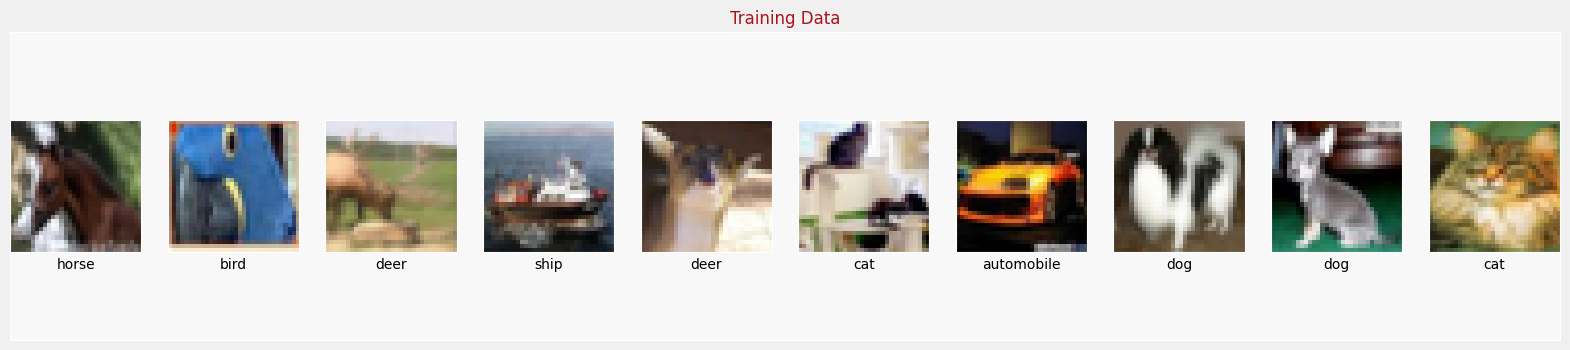

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

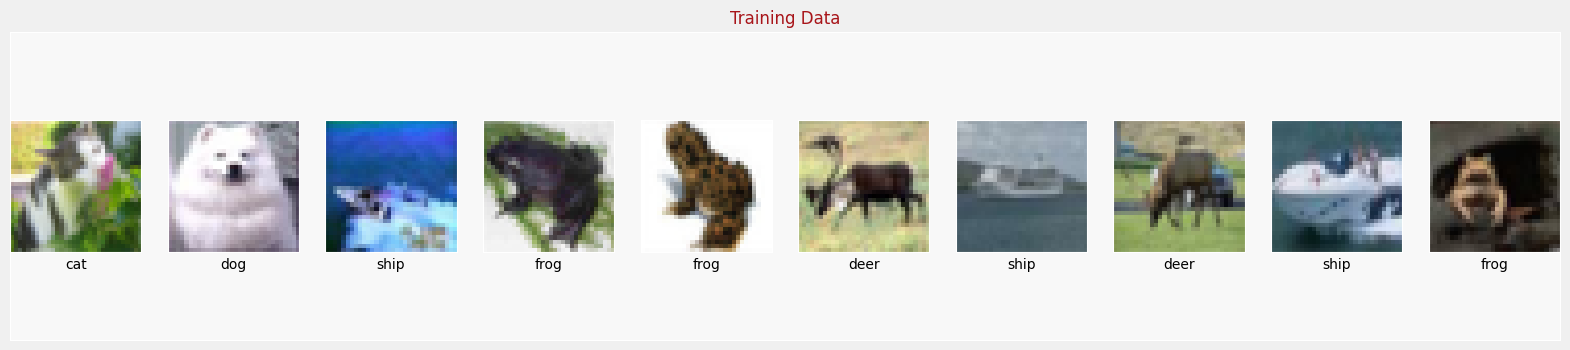

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [ ]:
validation_images[0].astype('float32').shape

(32, 32, 3)

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# this will take around 20 minutes to complete
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 474s 558ms/step - accuracy: 0.7668 - loss: 0.7314 - val_accuracy: 0.9154 - val_loss: 0.2482
Epoch 2/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 462s 538ms/step - accuracy: 0.9645 - loss: 0.1100 - val_accuracy: 0.9432 - val_loss: 0.1744
Epoch 3/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 423s 513ms/step - accuracy: 0.9898 - loss: 0.0381 - val_accuracy: 0.9487 - val_loss: 0.1583
Epoch 4/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 461s 538ms/step - accuracy: 0.9972 - loss: 0.0134 - val_accuracy: 0.9467 - val_loss: 0.1916


In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9485 - loss: 0.1905


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict on validation set
y_pred_probs = model.predict(valid_X, batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert true labels to numpy array
y_true = np.array(validation_labels)

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print classification report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# Print individual metrics
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"🎯 Precision (Macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"📥 Recall (Macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"📊 F1 Score (Macro): {f1_score(y_true, y_pred, average='macro'):.4f}")




157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step
📊 Classification Report:

              precision    recall  f1-score   support

    airplane       0.98      0.91      0.94      1000
  automobile       0.96      0.98      0.97      1000
        bird       0.88      0.97      0.92      1000
         cat       0.91      0.90      0.90      1000
        deer       0.94      0.95      0.95      1000
         dog       0.92      0.92      0.92      1000
        frog       0.98      0.95      0.96      1000
       horse       0.96      0.97      0.97      1000
        ship       0.98      0.97      0.97      1000
       truck       0.98      0.94      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

✅ Accuracy: 0.9467
🎯 Precision (Macro): 0.9478
📥 Recall (Macro): 0.9467
📊 F1 Score (Macro): 0.9468


157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step
        Class  False Positive Rate (FPR)  False Negative Rate (FNR)
0    airplane                     0.0024                      0.088
1  automobile                     0.0051                      0.015
2        bird                     0.0152                      0.034
3         cat                     0.0099                      0.101
4        deer                     0.0066                      0.050
5         dog                     0.0086                      0.080
6        frog                     0.0024                      0.049
7       horse                     0.0041                      0.032
8        ship                     0.0024                      0.028
9       truck                     0.0024                      0.056


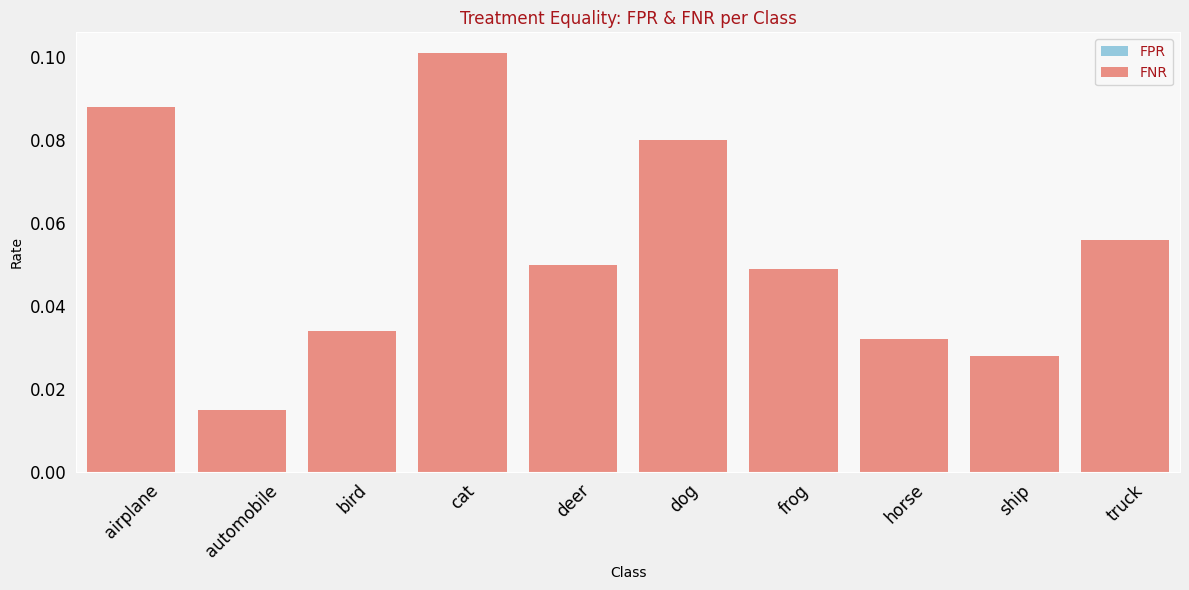

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Get predictions and true labels
y_pred_probs = model.predict(valid_X, batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(validation_labels)

# Class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Initialize result storage
results = []

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

for i, class_name in enumerate(classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    FPR = FP / (FP + TN + 1e-8)
    FNR = FN / (FN + TP + 1e-8)

    results.append({
        'Class': class_name,
        'False Positive Rate (FPR)': round(FPR, 4),
        'False Negative Rate (FNR)': round(FNR, 4)
    })

# Display results
df = pd.DataFrame(results)
print(df)

# Optional: visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='False Positive Rate (FPR)', data=df, color='skyblue', label='FPR')
sns.barplot(x='Class', y='False Negative Rate (FNR)', data=df, color='salmon', label='FNR')
plt.title("Treatment Equality: FPR & FNR per Class")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Predict labels
y_pred_probs = model.predict(valid_X, batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(validation_labels)

# Class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

# List to store metrics
results = []

# Compute FPR & FNR for each class
for i, class_name in enumerate(classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    FPR = FP / (FP + TN + 1e-8)
    FNR = FN / (FN + TP + 1e-8)

    results.append({
        'Class': class_name,
        'TP': int(TP),
        'FP': int(FP),
        'FN': int(FN),
        'TN': int(TN),
        'False Positive Rate (FPR)': round(FPR, 4),
        'False Negative Rate (FNR)': round(FNR, 4)
    })

# Create a DataFrame
df = pd.DataFrame(results)

# Print the table
print("📊 Treatment Equality Metrics Per Class:\n")
print(df.to_string(index=False))


157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step
📊 Treatment Equality Metrics Per Class:

     Class  TP  FP  FN   TN  False Positive Rate (FPR)  False Negative Rate (FNR)
  airplane 912  22  88 8978                     0.0024                      0.088
automobile 985  46  15 8954                     0.0051                      0.015
      bird 966 137  34 8863                     0.0152                      0.034
       cat 899  89 101 8911                     0.0099                      0.101
      deer 950  59  50 8941                     0.0066                      0.050
       dog 920  77  80 8923                     0.0086                      0.080
      frog 951  22  49 8978                     0.0024                      0.049
     horse 968  37  32 8963                     0.0041                      0.032
      ship 972  22  28 8978                     0.0024                      0.028
     truck 944  22  56 8978                     0.0024                      0.056


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Get predictions
y_pred_probs = model.predict(valid_X, batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(validation_labels)

# CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

results = []
epsilon = 1e-8

for i, class_name in enumerate(classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    FPR = FP / (FP + TN + epsilon)
    FNR = FN / (FN + TP + epsilon)
    TER = FPR / (FNR + epsilon)

    results.append({
        'Class': class_name,
        'FPR': round(FPR, 4),
        'FNR': round(FNR, 4),
        'Treatment Equality Ratio': round(TER, 4)
    })

df = pd.DataFrame(results)

print("📊 Treatment Equality Ratio Per Class:\n")
print(df.to_string(index=False))


157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step
📊 Treatment Equality Ratio Per Class:

     Class    FPR   FNR  Treatment Equality Ratio
  airplane 0.0024 0.088                    0.0278
automobile 0.0051 0.015                    0.3407
      bird 0.0152 0.034                    0.4477
       cat 0.0099 0.101                    0.0979
      deer 0.0066 0.050                    0.1311
       dog 0.0086 0.080                    0.1069
      frog 0.0024 0.049                    0.0499
     horse 0.0041 0.032                    0.1285
      ship 0.0024 0.028                    0.0873
     truck 0.0024 0.056                    0.0437


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score

# Assuming y_pred and y_true are already defined
# Get predictions, but resize validation data to the expected shape (32, 32)
y_pred_probs = model.predict(tf.image.resize(valid_X, (32, 32)), batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(validation_labels)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Calculate recall (True Positive Rate) for each class
equal_opportunity_results = []

# Calculate recall for each class individually
for i, class_name in enumerate(classes):
    # Calculate recall for each class (True Positive Rate)
    recall = recall_score(y_true, y_pred, labels=[i], average='micro')  # Change to 'micro' for multiclass
    equal_opportunity_results.append({
        'Class': class_name,
        'Equal Opportunity (Recall)': round(recall, 4)
    })

dp_df = pd.DataFrame(equal_opportunity_results)
print("📊 Equal Opportunity per Class:\n")
print(dp_df.to_string(index=False))




157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step
📊 Equal Opportunity per Class:

     Class  Equal Opportunity (Recall)
  airplane                         0.0
automobile                         0.0
      bird                         1.0
       cat                         0.0
      deer                         0.0
       dog                         0.0
      frog                         0.0
     horse                         0.0
      ship                         0.0
     truck                         0.0
